In [1]:
import cv2
import matplotlib.pyplot as plt
import glob
import os

In [2]:
def save2class(class_name, img):
    class_folder = glob.glob("classified/" + class_name + "/*")
    n = len(class_folder)
    cv2.imwrite("classified/" + class_name + "/{}.jpg".format(n), img)


def plot_fig(plots, detected_notes, no_all_matches):
    for i in range(len(plots)):
        plt.figure(figsize=(15, 7.5))
        plt.title(str(detected_notes[i]) + " Egyptian Pound(s)\n" + "No. of matched points = " + str(no_all_matches[i]),
                  fontsize=16)
        plt.imshow(plots[i])
        plt.show()


def cam_capture():
    test_notes = []
    # Camera capture
    cam = cv2.VideoCapture(0, cv2.CAP_DSHOW)
    
    while True:
        ret, frame = cam.read()
        if not ret:
            print("failed to grab frame")
            break
        
        cv2.imshow("test", frame)
        k = cv2.waitKey(1)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if k % 256 == 32:
            # SPACE pressed
            test_notes.append(frame)
            print("Image was captured successfully!")


        if k % 256 == 27:
            # Esc pressed
            break

    cam.release()
    cv2.destroyAllWindows()
    return test_notes

In [3]:
class Banknote:
    def __init__(self, image, kp, des, value=None):
        self.image = image
        self.value = value
        self.kp = kp
        self.des = des
    
    def match(self, other_note):
        
        matched_points = []
        
        # FLANN parameters to identify nearest 2 neighbours approximately
        FLANN_INDEX_LSH = 6
        index_params = dict(algorithm=FLANN_INDEX_LSH,
                            table_number=6,       # 12
                            key_size=12,          # 20
                            multi_probe_level=2)  # 2

        search_params = dict(checks=100)

        flann = cv2.FlannBasedMatcher(index_params, search_params)

        map(float, self.des)
        map(float, other_note.des)

        matches = flann.knnMatch(self.des, other_note.des, k=2)

        '''Applying Lowe's ratio criteria'''
        for (m, n) in matches:
            if m.distance < 0.65 * n.distance:
                matched_points.append([m])
        
        return matched_points

In [4]:
# Create ORB object
orb = cv2.ORB_create(1000)

In [5]:
# List of reference notes
ref_notes = []

# database images
database = glob.glob('reference/*')

for i in range(0, len(database)):
    # Load the training image
    img2 = cv2.imread(database[i], cv2.COLOR_BGR2RGB)
    kp2, des2 = orb.detectAndCompute(img2, None)
    value2 = int(database[i][10:13])
    
    current_ref_note = Banknote(image=img2, value=value2, kp=kp2, des=des2)
    
    ref_notes.append(current_ref_note)

In [6]:
# Query notes
test_notes = cam_capture() 
# Load the query image
for j, test in enumerate(test_notes):
    
    kp1, des1 = orb.detectAndCompute(test, None)
    current_test_note = Banknote(image=test, kp=kp1, des=des1)
    test_notes[j] = current_test_note
    

Image was captured successfully!
Image was captured successfully!
Image was captured successfully!
Image was captured successfully!
Image was captured successfully!
Image was captured successfully!
Image was captured successfully!
Image was captured successfully!
Image was captured successfully!
Image was captured successfully!


In [7]:
# List of detected input notes
detected_notes = []     

# List of matching plots for each detected note
plots = []              

# Total no. of matched points for each detected note
no_all_matches = []


'''Start Matching query images with reference images '''

# Finding similarities between input and reference images
for test_note in test_notes:
    
    threshold = 10           # Minimum matching points needed to accept the nearest reference image
    max_matched_points = 0   # Maximum number of matched points
    
    for ref_note in ref_notes:

        matched_points = test_note.match(ref_note)
        
        if len(matched_points) > threshold:
            max_matched_points = len(matched_points)
            threshold = max_matched_points
            chosen_note = ref_note
            matched_chosen_points = matched_points
            
    if max_matched_points == threshold:
        
        # Append recognized notes
        detected_notes.append(chosen_note.value)
        
        # Append max matches of the recognized note
        no_all_matches.append(max_matched_points)
        
        # Save the recognized note to its class directory
        save2class(str(chosen_note.value), test_note.image)   # Assign note to its class
       

        '''Drawing matches between keypoints'''
        draw_params = dict(matchColor=(0, 255, 0), 
                           singlePointColor=(255, 0, 0), 
                           flags=cv2.DrawMatchesFlags_DEFAULT)
        
        graph = cv2.drawMatchesKnn(test_note.image, 
                                   test_note.kp, 
                                   chosen_note.image, 
                                   chosen_note.kp, 
                                   matched_chosen_points, 
                                   None, 
                                   **draw_params)
       
        plots.append(graph)

    else:
        save2class("Anomaly", test_note.image)

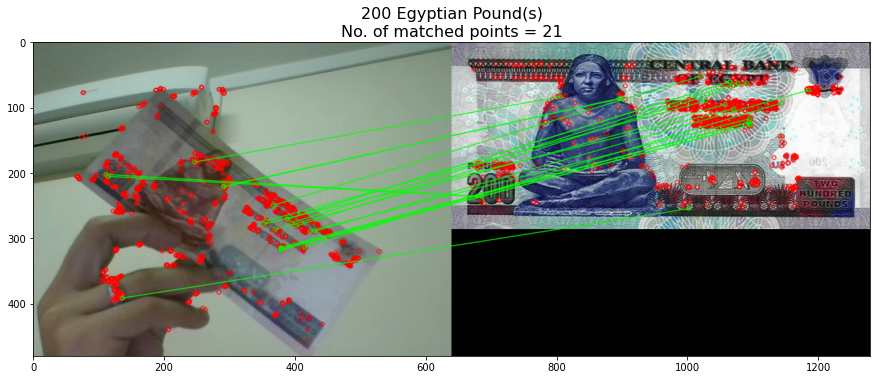

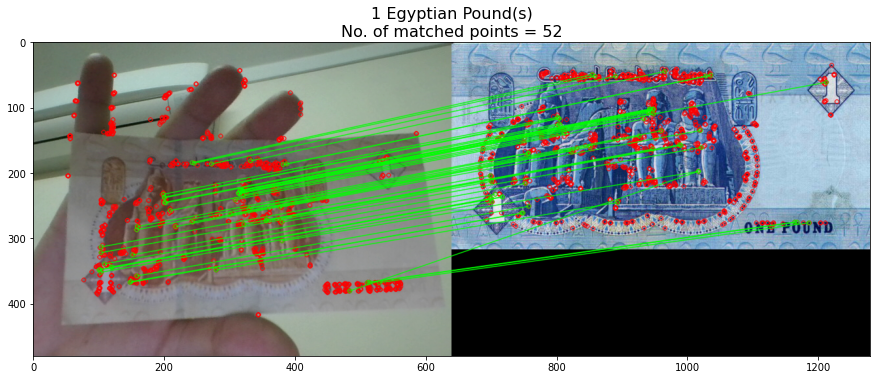

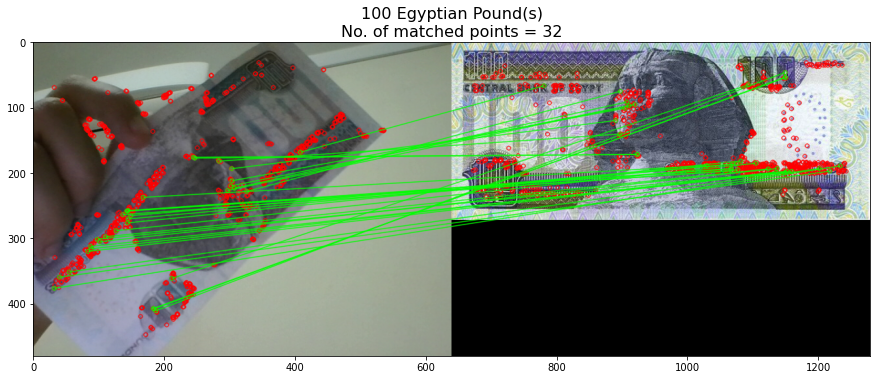

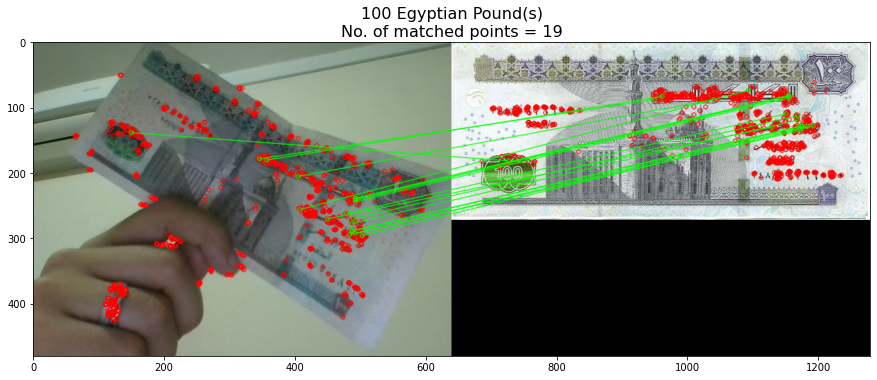

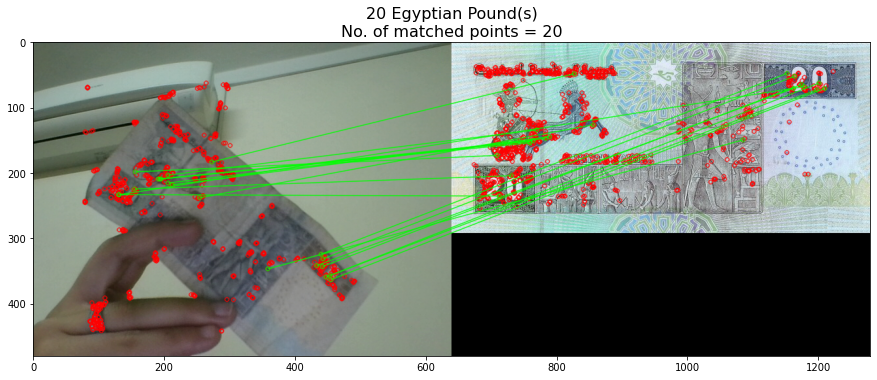

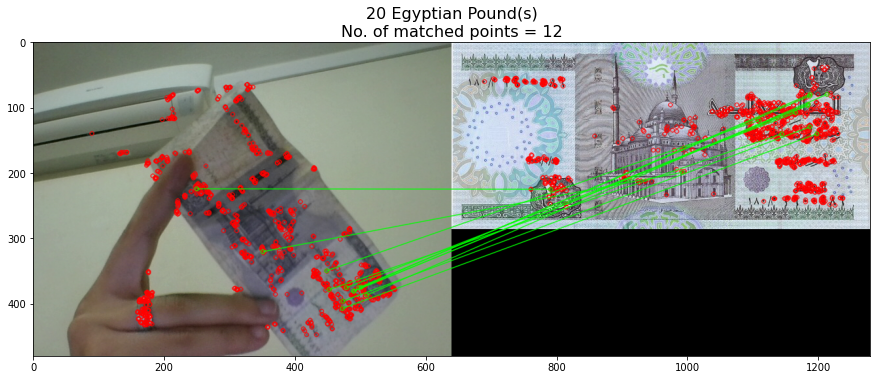

In [8]:
# Debug, plot figure
plot_fig(plots, detected_notes, no_all_matches)